<a href="https://colab.research.google.com/github/eel-eel-eel/ric1340/blob/main/ch06_01_exercise_answer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 文章分類の練習問題

※2023/04のGoogle colaboratoryのPython3.10へのアップデートに伴い、使用するライブラリを変更したため、コードを大幅に修正

ライブラリのインストール

In [ ]:
!pip install transformers[ja]==4.29.1 datasets==2.12.0 evaluate==0.4.0
!pip install --upgrade accelerate==0.19.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 33.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.4/81.4 kB 749.9 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 9.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 30.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 599.9/599.9 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 21.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 MB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 44.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━

文章分類の練習問題として、DBpedia Japaneseというウェブサイトのデータを用いて、文書分類の学習とテストを行ってみましょう。

DBpediaはLinked Open Dataとして公開するコミュニティプロジェクトです。コミュニティベースで日夜開発が進んでおり、知識・情報が体系化されています。今回は、これら体系化された記事をいくつかの観点から収集し、分類タスクに適したデータを作成します。

また、本練習問題では、収集したデータをあえてアンダーサンプリングして、少量データでの学習、データ量を変えた場合の学習をご自身で比較できるようにしています。コードの実装が完了しましたら、ぜひご自身で実験してみてください。

## データセット準備

DBpediaでは、SPARQLというクエリを用いてデータ収集することができます。今回は、Pythonから直接クエリを投げてデータを収集します。

In [ ]:
!pip install sparqlwrapper

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 528.1/528.1 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
companies_query = """select distinct ?name ?abstract where {
    ?companies <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:東証一部上場企業> .
    ?companies rdfs:label ?name .
    ?companies <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

In [ ]:
bands_query = """select distinct ?name ?abstract where {
    ?bands <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のロック・バンド> .
    ?bands rdfs:label ?name .
    ?bands <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

In [ ]:
gold_medalist_olympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のオリンピック金メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

silver_medalist_olympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のオリンピック銀メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

bronze_medalist_olympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のオリンピック銅メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""


gold_medalist_paralympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のパラリンピック金メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

silver_medalist_paralympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のパラリンピック銀メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

bronze_medalist_paralympics_query = """select distinct ?name ?abstract where {
    ?medalist <http://dbpedia.org/ontology/wikiPageWikiLink> <http://ja.dbpedia.org/resource/Category:日本のパラリンピック銅メダリスト> .
    ?medalist rdfs:label ?name .
    ?medalist <http://dbpedia.org/ontology/abstract> ?abstract .
}"""

In [ ]:
from SPARQLWrapper import SPARQLWrapper
sparql = SPARQLWrapper('http://ja.dbpedia.org/sparql')
sparql.setQuery(companies_query)
sparql.setReturnFormat('json')
response_companies = sparql.query().convert()
print("レコード数：", len(response_companies['results']['bindings']))


レコード数： 1936


In [ ]:
sparql.setQuery(bands_query)
sparql.setReturnFormat('json')
response_bands = sparql.query().convert()
print("レコード数：", len(response_bands['results']['bindings']))


レコード数： 1945


In [ ]:
medalist_queries =[gold_medalist_olympics_query, silver_medalist_olympics_query, bronze_medalist_olympics_query, gold_medalist_paralympics_query, silver_medalist_paralympics_query, bronze_medalist_paralympics_query]
medalist_abstract_list = []
for query in medalist_queries:
  sparql.setQuery(query)
  sparql.setReturnFormat('json')
  response = sparql.query().convert()
  print(len(response['results']['bindings']))
  temp_list = [result['abstract']['value'] for result in response['results']['bindings']]
  medalist_abstract_list = medalist_abstract_list + temp_list
print("レコード数：", len(medalist_abstract_list))

271
343
369
50
64
83
レコード数： 1180


In [ ]:
companies_abstract_list = [result['abstract']['value'] for result in response_companies['results']['bindings']]
bands_abstract_list = [result['abstract']['value'] for result in response_bands['results']['bindings']]

データフレームにまとめ、データを確認

In [ ]:
import pandas as pd

df_companies = pd.DataFrame(companies_abstract_list,columns=["abstract"])
df_bands = pd.DataFrame(bands_abstract_list,columns=["abstract"])
df_medalist = pd.DataFrame(medalist_abstract_list,columns=["abstract"])

In [ ]:
df_companies["label"] = int(0)
df_companies["label_name"] = "companies"

df_bands["label"] = int(1)
df_bands["label_name"] = "bands"

df_medalist["label"] = int(2)
df_medalist["label_name"] = "medalist"

In [ ]:
df_companies.head()

,abstract,label,label_name
0,"株式会社エービーシー・マート（英: ABC-MART,INC.）は、東京都渋谷区に本社を置く...",0,companies
1,"株式会社ACCESS（アクセス、ACCESS CO., LTD.）は、東京都千代田区に本社を...",0,companies
2,株式会社ADEKA（アデカ）は化学品・食品事業を担う創立100年を超える大手化学素材メーカー...,0,companies
3,AGC株式会社（エイジーシー、英: AGC Inc.）は世界最大級のガラスメーカー。1907...,0,companies
4,AGS株式会社（エージーエス、英: AGS Corporation）は、埼玉県さいたま市浦和...,0,companies


In [ ]:
df_bands.head()

,abstract,label,label_name
0,コンコンジャンプ（CONCONJUMP）は、日本の女性3人組+1バンド。,1,bands
1,サンダルバッヂ（サンダルバッヂ）は、日本のロックバンド。,1,bands
2,ザ☆ボンは、日本のロックバンドである。 大阪の音楽専門学校で出会い結成。ガールズバンドである...,1,bands
3,Smoky Medicine（スモーキー・メディスン）は、日本のロックバンド。,1,bands
4,ゼンマイ（ゼンマイ虫）は日本の福岡出身3人組ロックバンド。,1,bands


In [ ]:
df_medalist.head()

,abstract,label,label_name
0,"ウルフ・アロン（英語: Aaron Phillip Wolf, 1996年〈平成8年〉2月2...",2,medalist
1,ベイカー 茉秋（ベイカー ましゅう、1994年9月25日（27歳） - ）は、東京都千代田区...,2,medalist
2,三ヶ田 礼一（みかた れいいち、1967年1月14日 - ）は、1990年代に活躍したスキー...,2,medalist
3,三宅 義信（みやけ よしのぶ、1939年11月24日 - ）は、宮城県柴田郡村田町出身のオリ...,2,medalist
4,三栗 崇（みつくり たかし、1939年2月19日 - ）は、富山県出身の体操選手。富山県立富...,2,medalist


ここでデータフレームからランダムアンダーサンプリングを行い、それぞれのデータフレームのレコード数を100件にします。

In [ ]:
# 少量データを想定して、それぞれ100レコードになるようにアンダーサンプリング
rows = 100

df_companies = df_companies.sample(rows, random_state=42)
df_bands = df_bands.sample(rows, random_state=42)
df_medalist = df_medalist.sample(rows, random_state=42)

アンダーサンプリングしたら、一つのデータマートにまとめましょう

In [ ]:
df = pd.concat([df_companies, df_bands, df_medalist], axis=0).reset_index(drop=True)

In [ ]:
df.head

<bound method NDFrame.head of                                               abstract  label label_name
0           株式会社ステップは、神奈川県藤沢市に本部を置く、学習塾ステップを運営する総合学習塾。      0  companies
1    株式会社ベネッセコーポレーション（英: Benesse Corporation）は、通信教育...      0  companies
2    ペプチドリーム株式会社は、東京大学発のバイオベンチャー企業であり、産学連携による創薬研究と開...      0  companies
3    株式会社淀川製鋼所（よどがわせいこうしょ、英: Yodogawa Steel Works, ...      0  companies
4    日新電機株式会社（にっしんでんき、英: Nissin Electric Co,Ltd）は、京...      0  companies
..                                                 ...    ...        ...
295  北園 丈琉（きたぞの たける、2002年10月21日 - ）は、日本の体操競技選手である。大...      2   medalist
296  末續 慎吾（すえつぐ しんご、1980年6月2日 - ）は、日本の陸上選手。熊本県熊本市出身...      2   medalist
297  入江 陵介（いりえ りょうすけ、1990年1月24日 - ）は、日本の競泳の選手である。「イ...      2   medalist
298  野村 忠宏（のむら ただひろ、1974年12月10日 - ）は、奈良県北葛城郡広陵町出身の日...      2   medalist
299  杉山 賢人（すぎやま けんと、1968年12月12日 - ）は、静岡県沼津市出身の元プロ野球...      2   medalist

[300 rows x 3 columns]>

データマートを分割して、tsvに保存しておきます。

In [ ]:
train_ratio = 0.6
val_ratio = 0.2
test_ratio = 0.2

In [ ]:
from sklearn.model_selection import train_test_split

df_train = pd.DataFrame(columns=df.columns)
df_dev = pd.DataFrame(columns=df.columns)
df_test = pd.DataFrame(columns=df.columns)

label_list = list(df.label.unique())
for i in range(len(label_list)):
  temp_df = df[df['label'] == label_list[i]]
  temp_df_train, temp_df_test = train_test_split(temp_df, test_size=test_ratio, random_state=42)
  temp_df_train, temp_df_dev = train_test_split(temp_df_train, test_size=val_ratio/(test_ratio+train_ratio), random_state=42) #test_sizeの式は、val_ratioの値にするために

  df_train = pd.concat([df_train, temp_df_train], ignore_index=True)
  df_dev = pd.concat([df_dev, temp_df_dev], ignore_index=True)
  df_test = pd.concat([df_test, temp_df_test], ignore_index=True)

In [ ]:
!mkdir -p /content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/


df_train.to_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/train.tsv',  columns=['label', 'abstract'], sep='\t',
                        header=False, index=False)
df_dev.to_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/dev.tsv',  columns=['label', 'abstract'], sep='\t',
                      header=False, index=False)
df_test.to_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/test.tsv',  columns=['label', 'abstract'], sep='\t',
                       header=False, index=False)

In [ ]:
import pandas as pd
df_title_dataset_train = pd.read_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/train.tsv', sep='\t', names=['label', 'abstract'])
df_title_dataset_dev = pd.read_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/dev.tsv', sep='\t', names=['label', 'abstract'])
df_title_dataset_test = pd.read_csv('/content/drive/MyDrive/bert/6_1_dbpedia/dbpedia_japanese/dataset/test.tsv', sep='\t', names=['label', 'abstract'])

In [ ]:
df_train.groupby(["label"])["abstract"].count()

label
0    60
1    60
2    60
Name: abstract, dtype: int64

In [ ]:
df_dev.groupby(["label"])["abstract"].count()

label
0    20
1    20
2    20
Name: abstract, dtype: int64

In [ ]:
df_test.groupby(["label"])["abstract"].count()

label
0    20
1    20
2    20
Name: abstract, dtype: int64

## 文章分類モデルの作成

In [ ]:
from datasets import Dataset
from datasets import concatenate_datasets, load_dataset, DatasetDict

d = {
    'train':Dataset.from_pandas(df_train),
     'dev':Dataset.from_pandas(df_dev),
     'test':Dataset.from_pandas(df_test)
     }

dataset = DatasetDict(d)
dataset.set_format("pt")

#BertForSequenceClassificationの学習時のフォーマットに変更
dataset = dataset.rename_column("abstract", "text")
dataset = dataset.rename_column("label", "labels")

In [ ]:
label2id = {label: id for id, label in df_train[['label','label_name']].values}
id2label = {id: label for id, label in df_train[['label','label_name']].values}

In [ ]:
from transformers import BertJapaneseTokenizer
# cl-tohokuのモデルは512トークンまで対応しているが、512トークンではモデルがcolabのGPUメモリに乗らないため簡略化
n_tokens = 256

tokenizer = BertJapaneseTokenizer.from_pretrained('cl-tohoku/bert-base-japanese-whole-word-masking')
tokenizer.model_max_length = n_tokens
tokenizer.tokenize('今日はいい天気ですね。')

['今日', 'は', 'いい', '天気', 'です', 'ね', '。']

In [ ]:
def preprocess_function(examples):
    return tokenizer(examples["text"], truncation=True)

tokenized_dataset = dataset.map(preprocess_function, batched=True)

Map:   0%|          | 0/180 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

Map:   0%|          | 0/60 [00:00<?, ? examples/s]

In [ ]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
import evaluate
import numpy as np
accuracy = evaluate.load("accuracy")
f1 = evaluate.load("f1")
precision = evaluate.load("precision")
recall = evaluate.load("recall")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return f1.compute(predictions=predictions, references=labels, average="macro")

In [ ]:
!mkdir -p /content/drive/MyDrive/bert/6_1_dbpedia/model/

###  解答1

In [ ]:
# Q. BertForSequenceClassificationを使って、事前学習済みモデルを読み込みましょう

import torch
from transformers import BertForSequenceClassification, TrainingArguments, Trainer
model = BertForSequenceClassification.from_pretrained(
    pretrained_model_name_or_path='cl-tohoku/bert-base-japanese-whole-word-masking',
    num_labels=len(label2id),
    id2label=id2label,
    label2id=label2id)

Some weights of the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialize

###  解答2

In [ ]:
# Q. training_argsを定義しましょう

random_seed=42
batch_size=16
epoch=10
lr=1e-5
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/bert/6_1_dbpedia/model/",
    learning_rate=lr,
    optim='adamw_torch',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=epoch,
    evaluation_strategy="steps",
    push_to_hub=False,
    seed=random_seed,
    load_best_model_at_end=True,
    save_total_limit=1,
    save_strategy="steps"
)

### 解答3

In [ ]:
# Q. trainerを定義しましょう
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["dev"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

### 解答4

In [ ]:
# Q. trainerを使って、学習しましょう

trainer.train() # この行に学習を行うコードを実装しましょう

Step,Training Loss,Validation Loss


TrainOutput(global_step=120, training_loss=0.18141018549601237, metrics={'train_runtime': 58.8581, 'train_samples_per_second': 30.582, 'train_steps_per_second': 2.039, 'total_flos': 172721625296976.0, 'train_loss': 0.18141018549601237, 'epoch': 10.0})

## テストデータの推論

In [ ]:
predictions = trainer.predict(tokenized_dataset["test"])
preds = np.argmax(predictions.predictions, axis=-1)
trues = dataset["test"]["labels"].to('cpu').detach().numpy().copy()

In [ ]:
print('精度　 :{:.3f}'.format(accuracy.compute(predictions=preds, references=trues)["accuracy"]))
print('適合率 :{:.3f}'.format(precision.compute(predictions=preds, references=trues, average="macro")["precision"]))
print('再現率 :{:.3f}'.format(recall.compute(predictions=preds, references=trues, average="macro")["recall"]))
print('f-1値  :{:.3f}'.format(f1.compute(predictions=preds, references=trues, average="macro")["f1"]))

精度　 :1.000
適合率 :1.000
再現率 :1.000
f-1値  :1.000


0 companies
1 bands
2 medalist


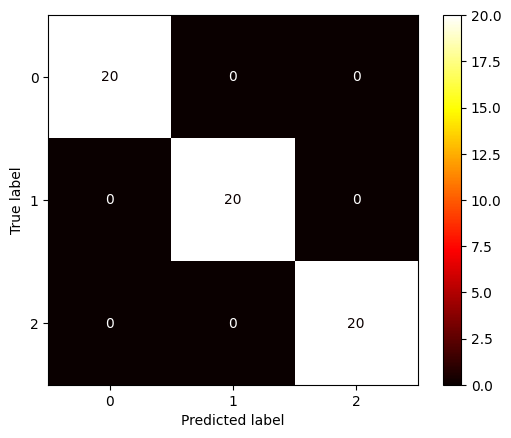

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

labels = [v for v in label2id.values()]

cm = confusion_matrix(trues, preds, labels=labels)
cmd = ConfusionMatrixDisplay(confusion_matrix=cm)
cmd.plot(cmap=plt.cm.hot, values_format='d')

for k,v in label2id.items(): print(v, k)

それぞれのカテゴリの中で使用されている単語や内容が特徴的なので、BERTがそれらの特徴さえ学べれば、問題としては簡単過ぎたかもしれません。

7章以降で記述しますが、自然言語処理の現場ではデータ数が少なくて困るということは、決して珍しくありません。データ量を横軸に、精度を縦軸にとって、どれほどのデータ量が必要なのか検討することもありますので、ご自身でもデータ量を変えながら、実験してみたください。また、データ量の変更にともなってエポック数やその他パラメータを変えるとどうなるかなど、実験してみてください。